So far, we've looked at **regression** and **classification**. These are both types of **supervised machine learning**. 
* In supervised learning, we train an algorithm to predict an **unknown variable** from **known variables**.

Another major type of machine learning is called **unsupervised learning**. 
* In unsupervised learning, we aren't trying to predict anything. Instead, we're finding patterns in data.

One of the main unsupervised learning techniques is called **clustering**. We use clustering when we're trying to explore a dataset, and understand the connections between the various rows and columns. For example, we can cluster NBA players based on their statistics. Here's how such a clustering might look:

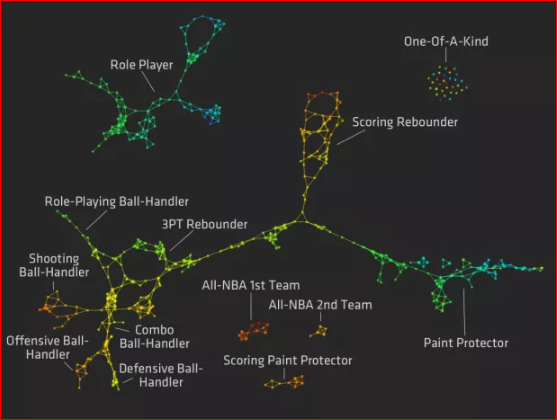

The clusters made it possible to discover player roles that might not have been noticed otherwise. [Here's](https://flowingdata.com/2012/03/21/redefining-nba-basketball-positions/) an article that describes how the clusters were created.

Clustering algorithms group similar rows together. There can be one or more groups in the data, and these groups form the clusters. As we look at the clusters, we can start to better understand the structure of the data.

Clustering is a key way to explore unknown data, and it's a very commonly used machine learning technique. In this project, we'll work on clustering US Senators based on how they voted.

In the US, the Senate votes on proposed legislation. Getting a bill passed by the Senate is a key step towards getting its provisions enacted. A majority vote is required to get a bill passed.

The results of these votes, known as `roll call votes`, are public, and available in a few places, including [here](https://github.com/unitedstates/congress).

Senators typically vote in accordance with how their political party votes, known as **voting along party lines**. In the US, the 2 main political parties are 
* The **Democrats**, who tend to be liberal, and 
* The **Republicans**, who tend to be conservative. 

Senators can also choose to be unaffiliated with a party, and vote as **Independents**, although very few choose to do so.

`114_congress.csv` contains all of the results of **roll call votes** from the **114th Senate**. Each row represents a single Senator, and each column represents a vote. 
* A `0` in a cell means the Senator voted **No** on the bill,
* `1` means the Senator voted **Yes**, and 
* `0.5` means the Senator **abstained**.

Here are the relevant columns:

* `name` -- The last name of the Senator.
* `party` -- the party of the Senator. The valid values are `D` for **Democrat**, `R` for **Republican**, and `I` for **Independent**.
* Several columns numbered like `00001`, `00004`, etc. Each of these columns represents the results of a single `roll call vote`.

Clustering voting data of Senators is particularly interesting because it can expose patterns that go deeper than party affiliation. For example, some Republicans are more liberal than the rest of their party. Looking at voting data can help us discover the Senators who are more or less in the mainstream of their party.

In [1]:
import pandas as pd

votes= pd.read_csv("114_congress.csv")

In [61]:
# How many Senators are in each party
print(votes['party'].value_counts())

R    54
D    44
I     2
Name: party, dtype: int64


In [8]:
#  "average" vote for each bill was
#  If the mean for a column is less than .5, more Senators voted against the bill, and vice versa if it's over .5.
print(votes.mean())

00001    0.325
00004    0.575
00005    0.535
00006    0.945
00007    0.545
00008    0.415
00009    0.545
00010    0.985
00020    0.525
00026    0.545
00032    0.410
00038    0.480
00039    0.510
00044    0.460
00047    0.370
dtype: float64


To group Senators together, we need some way to figure out how **close** the Senators are to each other. We'll then group together the Senators that are the closest. We can actually discover this distance mathematically, by finding how similar the votes of two Senators are. The closer together the voting records of two Senators, the more ideologically similar they are (voting the same way indicates that they share the same views).

To find the distance between two rows, we can use [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). The formula is: 

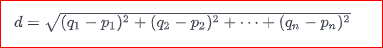

Let's say we have two Senator's voting records:

`name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
Alexander,R,TN,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0
Ayotte,R,NH,0,1,1,1,1,0,0,1,0,1,0,1,0,1,0`

If we took only the numeric vote columns, we'd have this Euclidean distance:

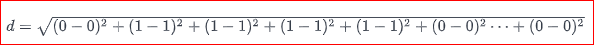

As we can see, these Senators are very similar! If we look at the votes above, they only disagree on 3 bills. The final Euclidean distance between these two Senators is `1.73`.

To compute Euclidean distance in Python, we can use the `euclidean_distances()` method in the **scikit-learn library**.


In [12]:
from sklearn.metrics.pairwise import euclidean_distances

In [27]:
#  Euclidean distance between the first row and the third row

distance = euclidean_distances(votes.iloc[0,3:].values.reshape(1,-1), votes.iloc[2,3:].values.reshape(1,-1)),
distance

(array([[3.31662479]]),)

We'll use an algorithm called [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to split our data into clusters. **k-means clustering** uses **Euclidean distance** to form clusters of similar Senators.

The **k-means algorithm** will group Senators who vote similarly on bills together, in clusters. Each cluster is assigned a center, and the Euclidean distance from each Senator to the center is computed. Senators are assigned to clusters based on which one they are closest to. From our background knowledge, we think that Senators will cluster along party lines.

The **k-means algorithm** requires us to specify the number of clusters upfront. Because we suspect that clusters will occur along party lines, and the vast majority of Senators are either Republicans or Democrats, we'll pick 2 for our number of clusters.

We'll use the [KMeans class](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from scikit-learn to perform the clustering. Because we aren't predicting anything, there's no risk of overfitting, so we'll train our model on the whole dataset. After training, we'll be able to extract cluster labels that indicate what cluster each Senator belongs to.

We can initialize the model like this:

`kmeans_model = KMeans(n_clusters=2, random_state=1)`

The above code will initialize the k-means model with `2` clusters, and a random state of `1` to allow for the same results to be reproduced whenever the algorithm is run.

We'll then be able to use the [fit_transform()](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_transform) method to fit the model to votes and get the distance of each Senator to each cluster.

The result will look like this:

`array([[ 3.12141628,  1.3134775 ],
   [ 2.6146248 ,  2.05339992],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 1.43833966,  2.96866004],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 0.31287498,  3.30758755],
   ...`

This is a NumPy array with two columns. The first column is the Euclidean distance from each Senator to the first cluster, and the second column is the Euclidean distance to the the second cluster. The values in the columns will indicate how **far** the Senator is from each cluster. The further away from the cluster, the less the Senator's voting history aligns with the voting history of the cluster.

In [28]:
from sklearn.cluster import KMeans

In [33]:
# Use the fit_transform() method to fit kmeans_model on the votes DataFrame.
# Only select columns after the first 3 from votes when fitting.

kmeans_model = KMeans(n_clusters=2, random_state=1)

senator_distance = kmeans_model.fit_transform(votes.iloc[:,3:])
print(senator_distance.shape)
senator_distance

(100, 2)


array([[3.12141628, 1.3134775 ],
       [2.6146248 , 2.05339992],
       [0.33960656, 3.41651746],
       [3.42004795, 0.24198446],
       [1.43833966, 2.96866004],
       [0.33960656, 3.41651746],
       [3.42004795, 0.24198446],
       [0.33960656, 3.41651746],
       [3.42004795, 0.24198446],
       [0.31287498, 3.30758755],
       [0.33960656, 3.41651746],
       [3.27058526, 0.96734144],
       [0.33960656, 3.41651746],
       [3.34875646, 0.53945585],
       [0.33960656, 3.41651746],
       [1.18084816, 3.12695614],
       [1.23852221, 3.13536063],
       [3.42004795, 0.24198446],
       [3.42004795, 0.24198446],
       [3.42004795, 0.24198446],
       [2.6146248 , 2.05339992],
       [0.58487332, 3.31421108],
       [3.42004795, 0.24198446],
       [3.42004795, 0.24198446],
       [3.42004795, 0.24198446],
       [3.42004795, 0.24198446],
       [3.56324683, 0.93036231],
       [3.42004795, 0.24198446],
       [1.73847904, 2.82326711],
       [0.33960656, 3.41651746],
       [3.

In [32]:
votes.shape

(100, 18)

We can use the Pandas method [`crosstab()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) to compute and display how many Senators from each party ended up in each cluster. The `crosstab()` method takes in two vectors or Pandas Series and computes how many times each unique value in the second vector occurs for each unique value in the first vector.

Here's an example:

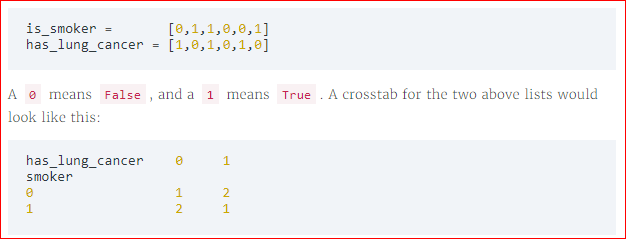

We can extract the cluster labels for each Senator from `kmeans_model` using `kmeans_model.labels_`, then we can make a table comparing these labels to `votes["party"]` with `crosstab()`. This will show us if the clusters tend to break down along party lines or not.

In [40]:
# extract the labels from kmeans_model. 
labels = kmeans_model.labels_

print(labels)
len(labels)

[1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1
 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0
 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0]


100

In [42]:
# comparing labels to votes["party"]

print(pd.crosstab(labels,votes["party"]))

party   D  I   R
row_0           
0      41  2   0
1       3  0  54


It looks like both of our clusters mostly broke down along party lines. 
* The first cluster contains `41 Democrats`, and `2 Independents`. 
* The second cluster contains `3 Democrats`, and `54 Republicans`.

No `Republicans` seem to have broken party ranks to vote with the `Democrats`, but `3 Democrats` are more similar to `Republicans` in their voting than their own party. Let's explore these 3 in more depth so we can figure out why that is.

We can do this by subsetting votes to only select rows where the `party` column is `D`, and the `labels` variable is `1`, indicating that the Senator is in the second cluster.

In [45]:
# Select all senators who were assigned to the second cluster that were Democrats.

democratic_outliers = votes[(labels == 1) & (votes["party"] == "D")]
democratic_outliers

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
42,Heitkamp,D,ND,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
56,Manchin,D,WV,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
74,Reid,D,NV,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


One great way to explore clusters is to visualize them using `matplotlib`. Earlier, we computed a `senator_distances array` that shows the distance from each Senator to the center of each cluster. We can treat these distances as `x` and `y` coordinates, and make a scatterplot that shows the position of each Senator. This works because the distances are relative to the cluster centers.

While making the scatterplot, we can also shade each point according to party affiliation. This will enable us to quickly look at the layout of the Senators, and see who crosses party lines.

No handles with labels found to put in legend.


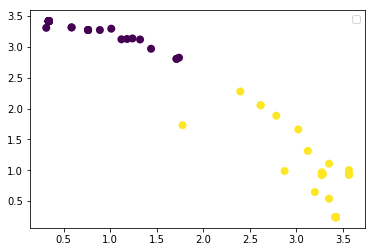

In [60]:
import matplotlib.pyplot as plt

plt.scatter(senator_distance[:,0], senator_distance[:,1], c = labels, linewidth = 2)#c=labels will shade the points according to label.
plt.show()

The most extreme Senators are those who are the furthest away from one cluster. For example, a radical Republican would be as far from the Democratic cluster as possible. Senators who are in between both clusters are more moderate, as they fall in between the views of the two parties.

If we look at the first few rows of `senator_distances`, we can start to see who is more extreme:
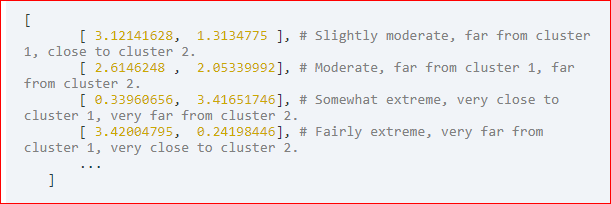

We'll create a formula to find **extremists** -- we'll **cube the distances** in both columns of `senator_distances`, then **add** them together. 

* The higher the exponent we raise a set of numbers to, the more separation we'll see between small values and low values. For instance, `squaring [1,2,3]` results in `[1,4,9]`, and `cubing` it results in `[1,8,27]`.

We cube the distances so that we can get a good amount of separation between the extremists who are farther away from a party, who have distances that look like `extremist = [3.4, 0.24]`, and `moderates`, whose distances look like `moderate = [2.6, 2]`.

* If we left the distances as is, we'd end up with `3.4 + 0.24 = 3.64`, and `2.6 + 2 = 4.6`, which would make the `moderate`, who is between both parties, seem extreme. 
* If we **cube**, we instead end up with `3.4 ** 3 + 0.24 ** 3 = 39.3`, and `2.6 ** 3 + 2 ** 3 = 25.5`, which correctly identifies the extremist.

In [56]:
# Compute an extremism rating by cubing every value in senator_distances, then finding the sum across each row. 
extremism = (senator_distance**3).sum(axis = 1)
extremism

array([32.67874845, 26.53232295, 39.91878062, 40.01754021, 29.13829736,
       39.91878062, 40.01754021, 39.91878062, 40.01754021, 36.21608334,
       39.91878062, 35.88975006, 39.91878062, 37.71051208, 39.91878062,
       32.22150039, 32.72193513, 40.01754021, 40.01754021, 40.01754021,
       26.53232295, 36.60334976, 40.01754021, 40.01754021, 40.01754021,
       40.01754021, 46.04687308, 40.01754021, 27.75802391, 39.91878062,
       40.01754021, 40.01754021, 39.91878062, 40.01754021, 40.01754021,
       36.60334976, 35.76549954, 39.91878062, 32.94241771, 40.01754021,
       40.01754021, 35.48052818, 25.55784136, 36.27181661, 39.91878062,
       40.01754021, 40.01754021, 40.01754021, 40.01754021, 35.74013614,
       35.48052818, 32.10668699, 31.81620746, 46.04687308, 39.91878062,
       38.93892871, 28.23496639, 39.91878062, 40.01754021, 27.07301769,
       40.01754021, 39.91878062, 39.91878062, 39.91878062, 40.01754021,
       40.01754021, 39.91878062, 39.91878062, 36.76309959, 46.04

In [58]:
votes["extremism"] = extremism
votes.sort_values("extremism", inplace = True, ascending = False)

In [59]:
print(votes.head(10))

         name party state  00001  00004  00005  00006  00007  00008  00009  \
98     Wicker     R    MS    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
53   Lankford     R    OK    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
69       Paul     R    KY    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
80      Sasse     R    NE    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
26       Cruz     R    TX    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
48    Johnson     R    WI    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
47    Isakson     R    GA    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
65  Murkowski     R    AK    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
64      Moran     R    KS    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
30       Enzi     R    WY    0.0    1.0    1.0    1.0    1.0    0.0    1.0   

    00010  00020  00026  00032  00038  00039  00044  00047  extremism  
98    0.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0  46.250476

Clustering is a powerful way to explore data and find patterns. **Unsupervised learning** is very commonly used with large datasets where it isn't obvious how to start with **supervised machine learning**. In general, it's a good idea to try **unsupervised learning** to explore a dataset before trying to use **supervised learning machine learning** models.